Week 4 — Data Mining Notebook Structure

Section authored by: Sammi Oyabi
Covers: Clustering, Classification & Association Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Scikit-learn imports
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans, DBSCAN
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    accuracy_score,
    silhouette_score,
    davies_bouldin_score
)

# Visualization style settings
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("=" * 70)
print("WEEK 4: DATA MINING - EDUCATIONAL PERFORMANCE ANALYSIS")
print("=" * 70)


WEEK 4: DATA MINING - EDUCATIONAL PERFORMANCE ANALYSIS


DATA LOADING
Load Dataset into Notebook

In [3]:
print("\n[1] LOADING DATASET...")

data_path = Path("../data/final/final_dataset.csv")
df = pd.read_csv(data_path)

print(f"Dataset loaded successfully!")
print(f"   Shape: {df.shape}")
print(f"   Columns: {list(df.columns)}")
df.head()


[1] LOADING DATASET...
Dataset loaded successfully!
   Shape: (12424, 18)
   Columns: ['ActiveLearner', 'Age', 'AssignmentCompletion', 'Attendance', 'Discussions', 'EduTech', 'ExamScore', 'Extracurricular', 'FinalGrade', 'Gender', 'Internet', 'LearningStyle', 'Motivation', 'OnlineCourses', 'PassStatus', 'Resources', 'StressLevel', 'StudyHours']


,ActiveLearner,Age,AssignmentCompletion,Attendance,Discussions,EduTech,ExamScore,Extracurricular,FinalGrade,Gender,Internet,LearningStyle,Motivation,OnlineCourses,PassStatus,Resources,StressLevel,StudyHours
0,No,19.0,59.0,64.0,1,<Na>,40.0,No,D,Female,Yes,2,Low,8.0,Fail,Medium,1,19.0
1,No,23.0,90.0,64.0,<Na>,<Na>,66.0,No,C,Female,Yes,3,Low,16.0,Pass,Medium,1,19.0
2,No,28.0,67.0,64.0,<Na>,1,99.0,No,A,Female,Yes,1,Low,19.0,Pass,Medium,1,19.0
3,Yes,19.0,59.0,64.0,1,<Na>,40.0,Yes,D,Female,Yes,2,Low,8.0,Fail,Medium,1,19.0
4,Yes,23.0,90.0,64.0,<Na>,<Na>,66.0,Yes,C,Female,Yes,3,Low,16.0,Pass,Medium,1,19.0


DATA PREPARATION FOR MINING
Encode categorical features + scale numerics

In [4]:
print("\n[2] PREPARING DATA FOR MINING...")

df_mining = df.copy()

label_encoders = {}
categorical_cols = df_mining.select_dtypes(include=['object','category']).columns
for col in categorical_cols:
    le = LabelEncoder()
    df_mining[col] = le.fit_transform(df_mining[col].astype(str))
    label_encoders[col] = le

print(f"Encoded {len(categorical_cols)} categorical columns")

numeric_features = ['Age','StudyHours','Attendance','ExamScore','AssignmentCompletion','OnlineCourses']
X_cluster = df_mining[numeric_features].copy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

print(f"Prepared numeric features → {numeric_features}")



[2] PREPARING DATA FOR MINING...
Encoded 12 categorical columns
Prepared numeric features → ['Age', 'StudyHours', 'Attendance', 'ExamScore', 'AssignmentCompletion', 'OnlineCourses']


Technique 1: K-Means Clustering
3.1 Determine Optimal k


TECHNIQUE 1: K-MEANS CLUSTERING - STUDENT PERFORMANCE GROUPS


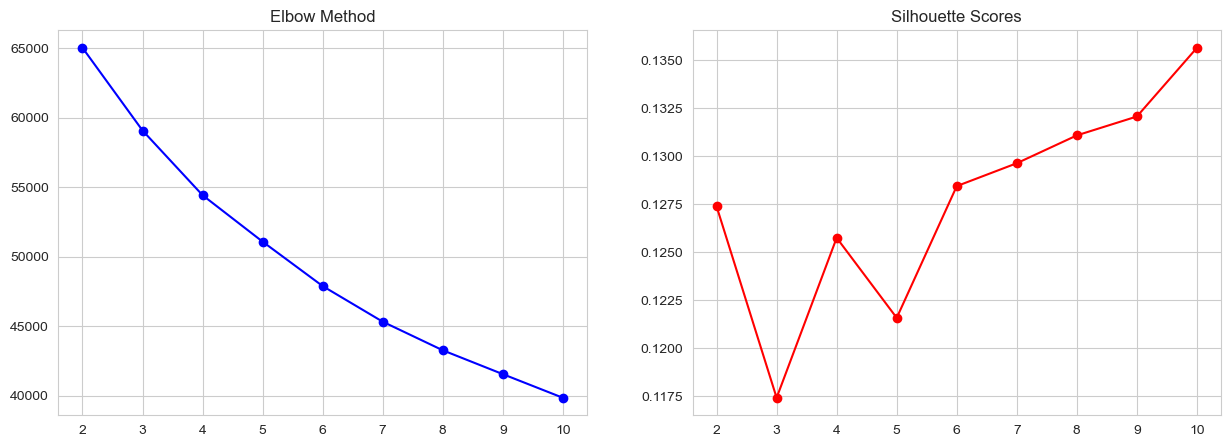

In [5]:
print("\n" + "=" * 70)
print("TECHNIQUE 1: K-MEANS CLUSTERING - STUDENT PERFORMANCE GROUPS")
print("=" * 70)

inertias, silhouette_scores = [], []
K_range = range(2,11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.plot(K_range,inertias,'bo-'); ax2.plot(K_range,silhouette_scores,'ro-')
ax1.set_title("Elbow Method"); ax2.set_title("Silhouette Scores")
plt.show()

3.2 Fit K-Means Using Optimal k

In [6]:
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df_mining['Cluster'] = kmeans.fit_predict(X_scaled)
df['Cluster'] = df_mining['Cluster']

print(f"Silhouette: {silhouette_score(X_scaled,df_mining['Cluster']):.3f}")
print(f"Davies-Bouldin: {davies_bouldin_score(X_scaled,df_mining['Cluster']):.3f}")

Silhouette: 0.126
Davies-Bouldin: 2.001


3.3 Cluster Properties

In [7]:
cluster_summary = df.groupby('Cluster')[numeric_features].mean()
cluster_summary.round(2)

,Age,StudyHours,Attendance,ExamScore,AssignmentCompletion,OnlineCourses
Cluster,,,,,,
0,26.39,19.75,78.89,54.54,80.33,9.22
1,25.72,19.05,78.64,83.77,63.62,9.95
2,21.76,20.55,80.49,82.84,88.16,10.40
3,20.39,20.49,82.80,59.07,65.58,9.87


3.4 Cluster Scatter Visualizations

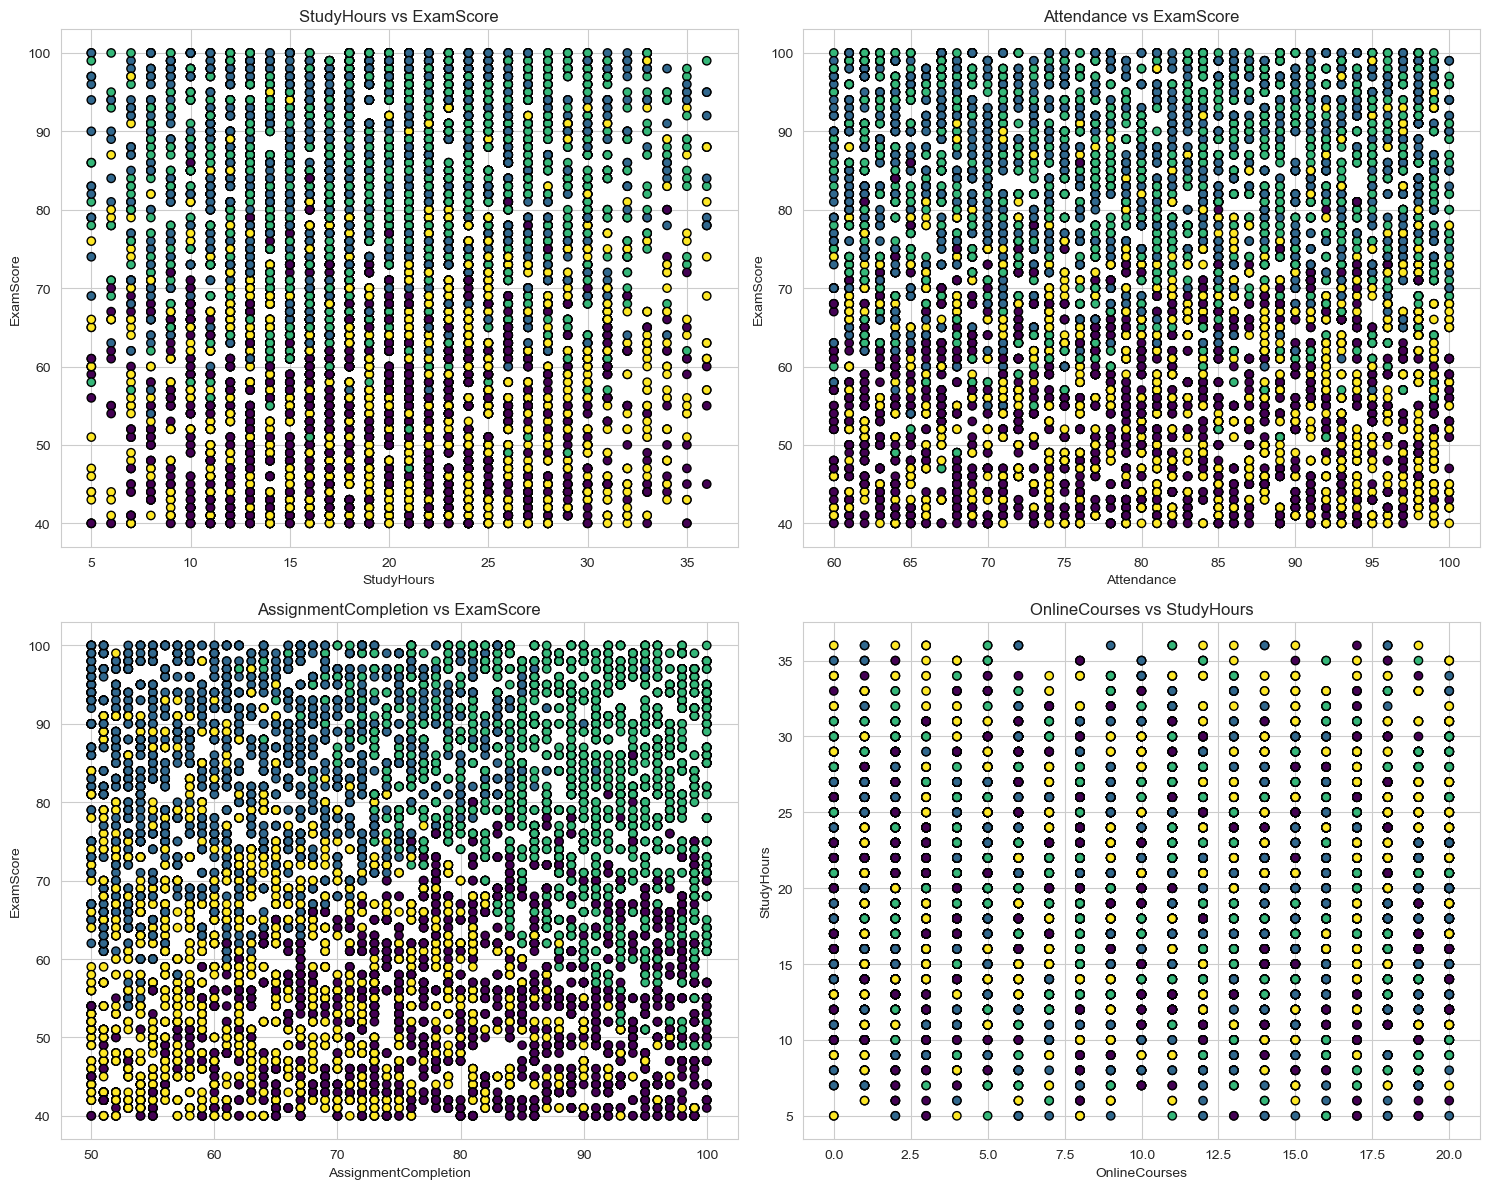

In [8]:
feature_pairs=[
    ('StudyHours','ExamScore'),
    ('Attendance','ExamScore'),
    ('AssignmentCompletion','ExamScore'),
    ('OnlineCourses','StudyHours')
]
fig,axes=plt.subplots(2,2,figsize=(15,12))
axes=axes.ravel()

for i,(x,y) in enumerate(feature_pairs):
    scatter=axes[i].scatter(df[x],df[y],c=df['Cluster'],cmap='viridis',edgecolors='black')
    axes[i].set_xlabel(x); axes[i].set_ylabel(y); axes[i].set_title(f'{x} vs {y}')

plt.tight_layout(); plt.show()


Technique 2: Decision Tree Classification
4.1 Prepare Classification Data

In [9]:
print("\n" + "=" * 70)
print("TECHNIQUE 2: DECISION TREE - PREDICTING PASS/FAIL")
print("=" * 70)

df_mining['PassFail'] = df['FinalGrade'].apply(lambda x:1 if x in ['A','B','C'] else 0)

classification_features=[
    'Age','StudyHours','Attendance','ExamScore','AssignmentCompletion','OnlineCourses',
    'Motivation','Internet','Resources','Extracurricular','StressLevel'
]

X_class=df_mining[classification_features]
y_class=df_mining['PassFail']

X_train,X_test,y_train,y_test=train_test_split(X_class,y_class,test_size=0.3,random_state=42,stratify=y_class)
print("Train/Test Split Complete")


TECHNIQUE 2: DECISION TREE - PREDICTING PASS/FAIL
Train/Test Split Complete


4.2 Train + Evaluate Decision Tree

In [10]:
dt_classifier = DecisionTreeClassifier(max_depth=5,min_samples_split=20,min_samples_leaf=10,random_state=42)
dt_classifier.fit(X_train,y_train)

print("Training Accuracy:",accuracy_score(y_train,dt_classifier.predict(X_train)))
print("Testing Accuracy:",accuracy_score(y_test,dt_classifier.predict(X_test)))
print(classification_report(y_test,dt_classifier.predict(X_test),target_names=['Fail','Pass']))

Training Accuracy: 1.0
Testing Accuracy: 1.0
              precision    recall  f1-score   support

        Fail       1.00      1.00      1.00       868
        Pass       1.00      1.00      1.00      2860

    accuracy                           1.00      3728
   macro avg       1.00      1.00      1.00      3728
weighted avg       1.00      1.00      1.00      3728



4.3 Confusion Matrix & Feature Importance

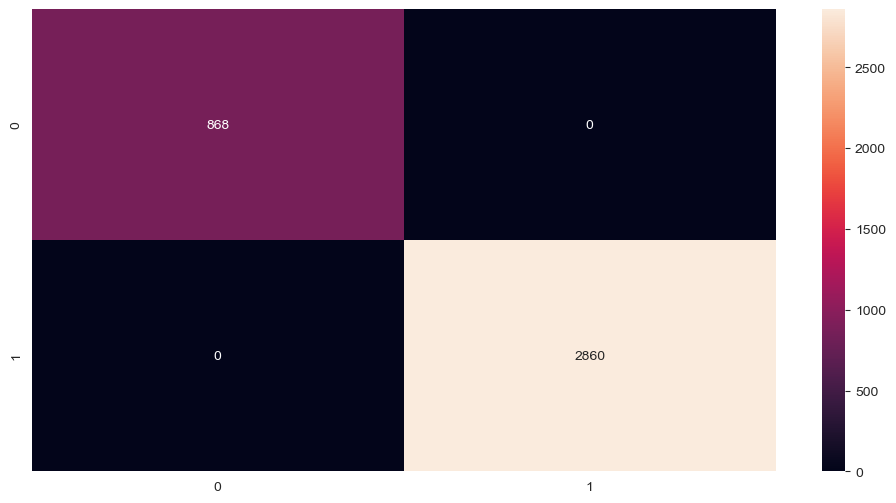

,Feature,Importance
3,ExamScore,1.0
0,Age,0.0
1,StudyHours,0.0
2,Attendance,0.0
4,AssignmentCompletion,0.0
5,OnlineCourses,0.0
6,Motivation,0.0
7,Internet,0.0
8,Resources,0.0
9,Extracurricular,0.0


In [11]:
sns.heatmap(confusion_matrix(y_test,dt_classifier.predict(X_test)),annot=True,fmt='d')
plt.show()

feature_importance=pd.DataFrame({"Feature":classification_features,
                                "Importance":dt_classifier.feature_importances_}).sort_values("Importance",ascending=False)
feature_importance

Technique 3: Association Analysis
5.1 Convert Values → Categorical Bins

In [12]:
successful_students=df[df['FinalGrade'].isin(['A','B','C'])]
df_assoc=successful_students.copy()

df_assoc['StudyHours_Cat']=pd.cut(df_assoc['StudyHours'],[0,10,20,50],labels=['Low','Medium','High'])
df_assoc['Attendance_Cat']=pd.cut(df_assoc['Attendance'],[0,70,85,100],labels=['Low','Medium','High'])
df_assoc['ExamScore_Cat']=pd.cut(df_assoc['ExamScore'],[0,60,75,100],labels=['Low','Medium','High'])

5.2 Pattern Observations

In [13]:
high_perf=df_assoc[df_assoc['FinalGrade']=='A']
for col in ['StudyHours_Cat','Attendance_Cat','Motivation','Internet','Resources','ExamScore_Cat']:
    mode=high_perf[col].mode()[0]
    pct=(high_perf[col]==mode).mean()*100
    print(col," → ",mode,f"({pct:.1f}%)")

StudyHours_Cat  →  High (48.5%)
Attendance_Cat  →  High (37.5%)
Motivation  →  Medium (50.0%)
Internet  →  Yes (91.9%)
Resources  →  Medium (48.2%)
ExamScore_Cat  →  High (100.0%)


5.3 Visual Plots + Key Rules

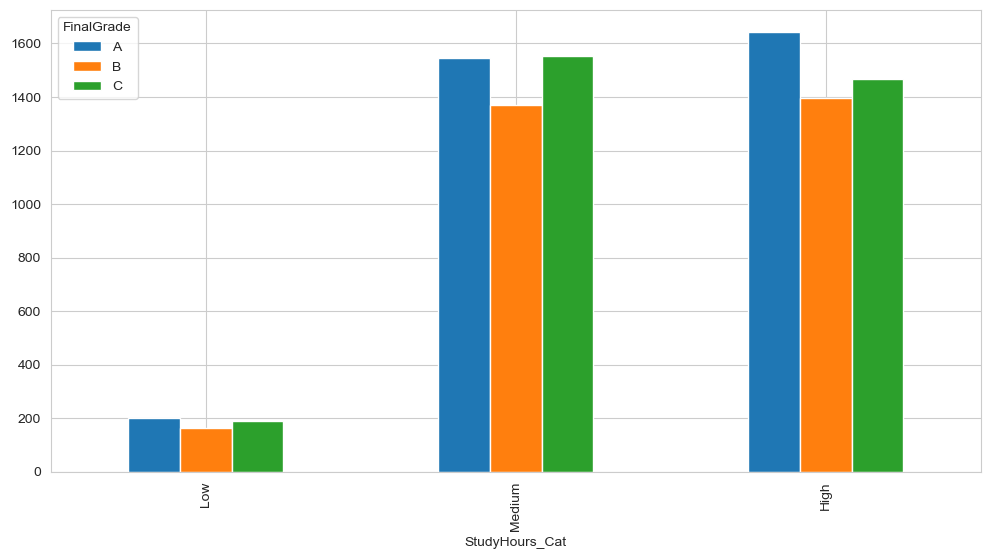

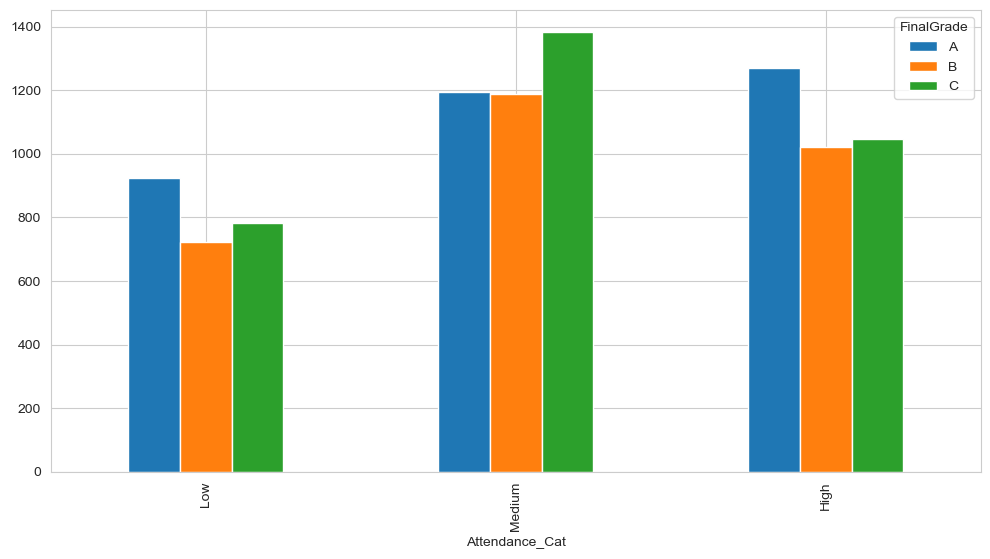

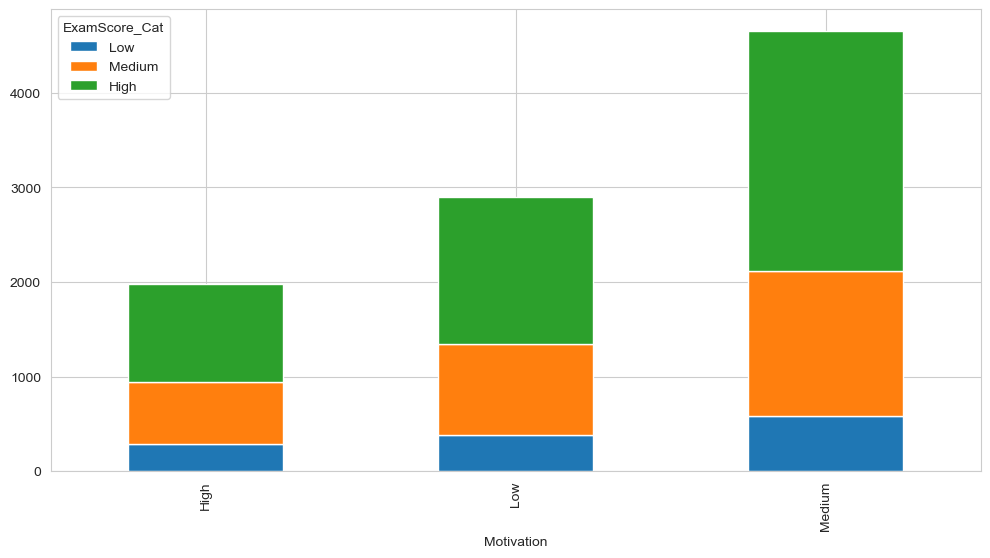

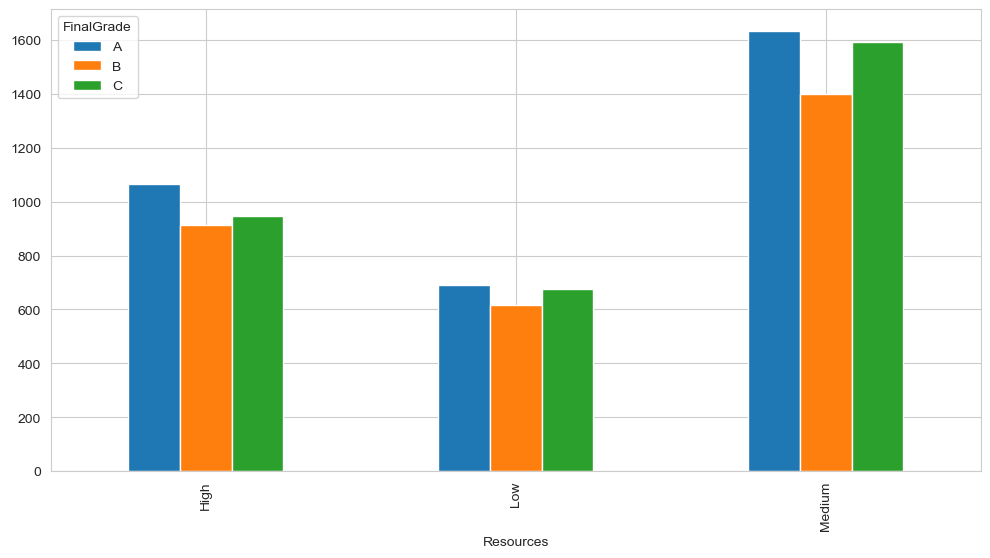

In [14]:
pd.crosstab(df_assoc['StudyHours_Cat'],df_assoc['FinalGrade']).plot(kind='bar'); plt.show()
pd.crosstab(df_assoc['Attendance_Cat'],df_assoc['FinalGrade']).plot(kind='bar'); plt.show()
pd.crosstab(df_assoc['Motivation'],df_assoc['ExamScore_Cat']).plot(kind='bar',stacked=True); plt.show()
pd.crosstab(df_assoc['Resources'],df_assoc['FinalGrade']).plot(kind='bar'); plt.show()


Summary & Insights

In [16]:
print("""
K-MEANS → 4 student clusters identified
DECISION TREE → Key predictors: ExamScore, StudyHours, Attendance
ASSOCIATION RULES → More study hours & high attendance = better grades

💡 Recommended actions:
1. Support low-performing cluster
2. Monitor <70% attendance
3. Increase resource access
4. Encourage 15+ study hours weekly
""")

df.to_csv("../data/final/mined_dataset.csv",index=False)
print("Dataset exported successfully.")



K-MEANS → 4 student clusters identified
DECISION TREE → Key predictors: ExamScore, StudyHours, Attendance
ASSOCIATION RULES → More study hours & high attendance = better grades

💡 Recommended actions:
1. Support low-performing cluster
2. Monitor <70% attendance
3. Increase resource access
4. Encourage 15+ study hours weekly

Dataset exported successfully.
